# 1. Data Selection and Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
df.shape

(142193, 24)

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [5]:
city = "Sydney"
df_Sydney = df[df["Location"] == city].copy()

In [6]:
df_Sydney.shape

(3337, 24)

In [7]:
df_Sydney.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [8]:
selected_features = [
    "Rainfall",       # Target
    "MinTemp",
    "MaxTemp",
    "Humidity3pm",
    "Pressure3pm",
    "WindSpeed3pm",
    "Cloud3pm",
    "RainToday"       # Binary indicator
]

In [9]:
df_selected = df_Sydney[selected_features]

In [10]:
missing_values = df_selected.isnull().sum()

In [11]:
print("Missing values per feature:")
print(missing_values)

Missing values per feature:
Rainfall          6
MinTemp           3
MaxTemp           2
Humidity3pm      13
Pressure3pm      19
WindSpeed3pm     25
Cloud3pm        561
RainToday         6
dtype: int64


## Missing Value Handling Strategy

We applied different imputation methods depending on the data type and distribution of each feature:

- **MinTemp & MaxTemp**: Used **mean imputation** because these are continuous variables with likely normal distributions. Mean works well when the data is symmetric and not heavily skewed.

- **Humidity3pm & WindSpeed3pm**: Used **median imputation** because these features can be skewed or have outliers (e.g., sudden humidity drops or wind spikes). Median is more robust in such cases.

- **Pressure3pm**: Used **mean imputation** assuming atmospheric pressure has a fairly stable, normal distribution.

- **Cloud3pm**: Used **mode imputation** because it is a categorical/ordinal feature (values from 0 to 8). The most frequent cloud cover is a good estimate.

- **RainToday**: Used **mode imputation** since it's a binary categorical feature ('Yes' or 'No') and using the most frequent value is typically reliable.

- **Rainfall**: Used **median imputation** to minimize the effect of outliers (heavy rain days).

These strategies ensure our dataset remains as complete and unbiased as possible without introducing distortions from inappropriate replacements.


In [12]:
# Handle missing values
df_selected["MinTemp"].fillna(df_selected["MinTemp"].mean(), inplace=True)
df_selected["MaxTemp"].fillna(df_selected["MaxTemp"].mean(), inplace=True)
df_selected["Humidity3pm"].fillna(df_selected["Humidity3pm"].median(), inplace=True)
df_selected["Pressure3pm"].fillna(df_selected["Pressure3pm"].mean(), inplace=True)
df_selected["WindSpeed3pm"].fillna(df_selected["WindSpeed3pm"].median(), inplace=True)
df_selected["Cloud3pm"].fillna(df_selected["Cloud3pm"].mode()[0], inplace=True)
df_selected["RainToday"].fillna(df_selected["RainToday"].mode()[0], inplace=True)
df_selected["Rainfall"].fillna(df_selected["Rainfall"].median(), inplace=True)

In [13]:
missing_values_after_fill = df_selected.isnull().sum()


In [14]:
print(missing_values_after_fill)

Rainfall        0
MinTemp         0
MaxTemp         0
Humidity3pm     0
Pressure3pm     0
WindSpeed3pm    0
Cloud3pm        0
RainToday       0
dtype: int64


In [15]:
# Compute z-scores
rainfall_z = (df_selected["Rainfall"] - df_selected["Rainfall"].mean()) / df_selected["Rainfall"].std()
maxtemp_z = (df_selected["MaxTemp"] - df_selected["MaxTemp"].mean()) / df_selected["MaxTemp"].std()

# Identify outliers (|z| > 3)
rainfall_outliers = df_selected[np.abs(rainfall_z) > 3]
maxtemp_outliers = df_selected[np.abs(maxtemp_z) > 3]

# Count outliers
print(f"Rainfall outliers: {rainfall_outliers.shape[0]}")
print(f"MaxTemp outliers: {maxtemp_outliers.shape[0]}")


Rainfall outliers: 71
MaxTemp outliers: 28


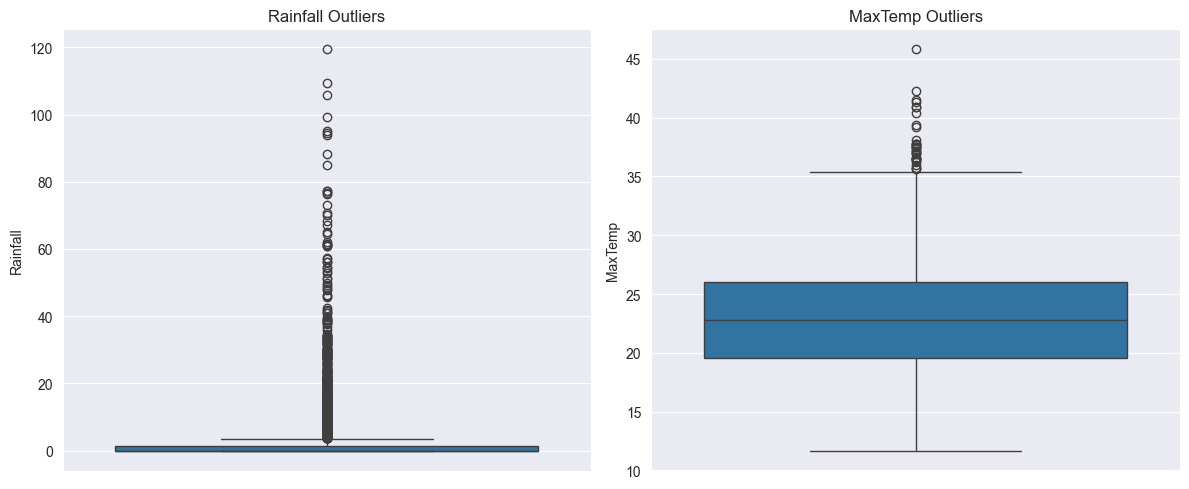

In [16]:
# Visualize outliers using boxplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_selected["Rainfall"])
plt.title("Rainfall Outliers")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_selected["MaxTemp"])
plt.title("MaxTemp Outliers")

plt.tight_layout()
plt.show()


In [17]:
# Define threshold
z_threshold = 3

# Recalculate z-scores
rainfall_z = (df_selected["Rainfall"] - df_selected["Rainfall"].mean()) / df_selected["Rainfall"].std()
maxtemp_z = (df_selected["MaxTemp"] - df_selected["MaxTemp"].mean()) / df_selected["MaxTemp"].std()

# Create mask for valid (non-outlier) entries
valid_rows = (np.abs(rainfall_z) <= z_threshold) & (np.abs(maxtemp_z) <= z_threshold)

# Filtered dataset without outliers
df_clean = df_selected[valid_rows].copy()


In [18]:
# Select columns to summarize
features = ["Rainfall", "MaxTemp"]

# Compute statistics before removal
summary_before = df_selected[features].agg(["mean", "median", "std"]).T
summary_before.columns = ["Mean (Before)", "Median (Before)", "Std Dev (Before)"]

# Compute statistics after removal
summary_after = df_clean[features].agg(["mean", "median", "std"]).T
summary_after.columns = ["Mean (After)", "Median (After)", "Std Dev (After)"]

# Combine for comparison
summary_comparison = pd.concat([summary_before, summary_after], axis=1)
summary_comparison


,Mean (Before),Median (Before),Std Dev (Before),Mean (After),Median (After),Std Dev (After)
Rainfall,3.324243,0.0,9.887277,2.199382,0.00,5.387403
MaxTemp,23.002339,22.8,4.493290,22.935517,22.85,4.264110


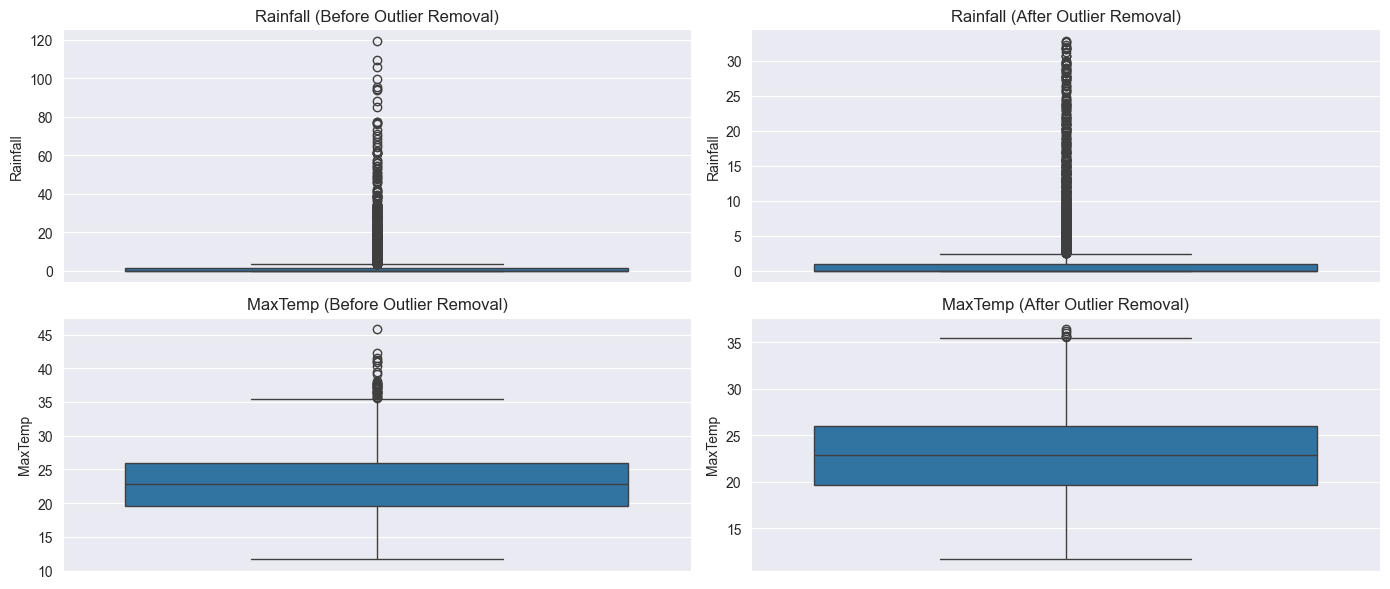

In [19]:
# Set up visual comparison
plt.figure(figsize=(14, 6))

# Rainfall
plt.subplot(2, 2, 1)
sns.boxplot(y=df_selected["Rainfall"])
plt.title("Rainfall (Before Outlier Removal)")

plt.subplot(2, 2, 2)
sns.boxplot(y=df_clean["Rainfall"])
plt.title("Rainfall (After Outlier Removal)")

# MaxTemp
plt.subplot(2, 2, 3)
sns.boxplot(y=df_selected["MaxTemp"])
plt.title("MaxTemp (Before Outlier Removal)")

plt.subplot(2, 2, 4)
sns.boxplot(y=df_clean["MaxTemp"])
plt.title("MaxTemp (After Outlier Removal)")

plt.tight_layout()
plt.show()


In [20]:
# Compute correlations
correlation_matrix = df_clean.corr(numeric_only=True)
correlation_with_rainfall = correlation_matrix["Rainfall"].sort_values(ascending=False)

# Display top correlations
print("Correlation with Rainfall:")
print(correlation_with_rainfall)


Correlation with Rainfall:
Rainfall        1.000000
Humidity3pm     0.283576
Cloud3pm        0.186503
MinTemp         0.040682
Pressure3pm     0.021585
WindSpeed3pm   -0.000783
MaxTemp        -0.110901
Name: Rainfall, dtype: float64


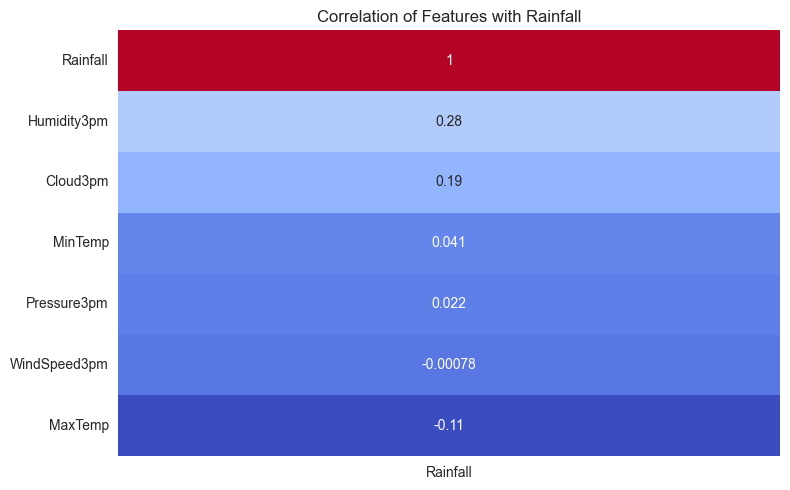

In [21]:
# Heatmap of correlations
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_with_rainfall.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation of Features with Rainfall")
plt.tight_layout()
plt.show()


In [22]:
# Select top 5 features (excluding Rainfall itself)
top_features = correlation_with_rainfall.drop("Rainfall").abs().sort_values(ascending=False).head(5)
print("Top 5 features for Rainfall prediction:")
print(top_features)


Top 5 features for Rainfall prediction:
Humidity3pm    0.283576
Cloud3pm       0.186503
MaxTemp        0.110901
MinTemp        0.040682
Pressure3pm    0.021585
Name: Rainfall, dtype: float64


In [23]:
# Set random seed for reproducibility
random_seed = 42

# Shuffle the dataset
df_shuffled = df_clean.sample(frac=1, random_state=random_seed).reset_index(drop=True)

# Split index
split_index = int(0.8 * len(df_shuffled))

# Create train and test sets
df_train = df_shuffled[:split_index].copy()
df_test = df_shuffled[split_index:].copy()

# Confirm sizes
print(f"Training set size: {df_train.shape[0]}")
print(f"Test set size: {df_test.shape[0]}")


Training set size: 2590
Test set size: 648


# Part I: Linear Regression (Multivariable)

In [24]:
# Prepare feature matrix and target vector for training
features = top_features.index.tolist()  # Use top 5 features from correlation
X_train = df_train[features].values
y_train = df_train["Rainfall"].values

# Add bias (intercept) term to design matrix
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]

# Compute weights using the Normal Equation
w = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

# Display weights with labels
print("Estimated Weights (Normal Equation):")
for i, coef in enumerate(w):
    label = "Intercept" if i == 0 else features[i - 1]
    print(f"{label}: {coef:.4f}")


Estimated Weights (Normal Equation):
Intercept: 47.2597
Humidity3pm: 0.0744
Cloud3pm: 0.1435
MaxTemp: -0.1833
MinTemp: 0.0469
Pressure3pm: -0.0456


In [26]:
# Create a DataFrame version of the design matrix (for documentation/explanation)
design_matrix_df = pd.DataFrame(X_train_bias, columns=["Intercept"] + features)

# Show first few rows of the design matrix
print("Design Matrix (with Intercept):")
display(design_matrix_df.head())


Design Matrix (with Intercept):


,Intercept,Humidity3pm,Cloud3pm,MaxTemp,MinTemp,Pressure3pm
0,1.0,50.0,7.0,18.3,6.9,1032.0
1,1.0,58.0,6.0,25.6,17.3,1015.7
2,1.0,81.0,7.0,22.6,18.0,1018.5
3,1.0,56.0,7.0,26.9,19.0,1008.4
4,1.0,65.0,8.0,24.2,16.0,1018.5


In [27]:
# Create a DataFrame of weights for better readability
weight_labels = ["Intercept"] + features
weights_df = pd.DataFrame({
    "Feature": weight_labels,
    "Weight": w
})

# Sort by absolute weight value (excluding intercept)
weights_sorted = weights_df[weights_df["Feature"] != "Intercept"].copy()
weights_sorted["AbsWeight"] = weights_sorted["Weight"].abs()
weights_sorted = weights_sorted.sort_values(by="AbsWeight", ascending=False)

# Display weights
print("Estimated Weights:")
display(weights_df)

print("\nFeature Influence (most to least):")
display(weights_sorted[["Feature", "Weight"]])


Estimated Weights:


,Feature,Weight
0,Intercept,47.259695
1,Humidity3pm,0.074351
2,Cloud3pm,0.143542
3,MaxTemp,-0.183268
4,MinTemp,0.046873
5,Pressure3pm,-0.045557



Feature Influence (most to least):


,Feature,Weight
3,MaxTemp,-0.183268
2,Cloud3pm,0.143542
1,Humidity3pm,0.074351
4,MinTemp,0.046873
5,Pressure3pm,-0.045557


Training MSE: 26.1140
Test MSE: 26.9080


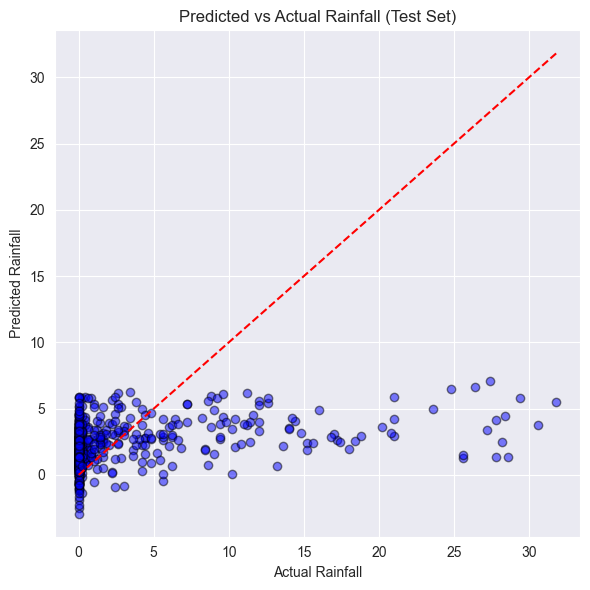

In [28]:
# --- Prepare test data ---
X_test = df_test[features].values
y_test = df_test["Rainfall"].values
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]

# --- Predict rainfall ---
y_pred_train = X_train_bias @ w
y_pred_test = X_test_bias @ w

# --- Compute MSE manually ---
mse_train = np.mean((y_train - y_pred_train) ** 2)
mse_test = np.mean((y_test - y_pred_test) ** 2)

print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

# --- Plot predicted vs actual rainfall ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', edgecolor='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Rainfall")
plt.ylabel("Predicted Rainfall")
plt.title("Predicted vs Actual Rainfall (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# --- Remove 'Humidity3pm' from features ---
ablated_features = [f for f in features if f != "Humidity3pm"]

# --- Rebuild design matrix without 'Humidity3pm' ---
X_train_ab = df_train[ablated_features].values
X_train_ab_bias = np.c_[np.ones(X_train_ab.shape[0]), X_train_ab]
y_train_ab = df_train["Rainfall"].values

# --- Retrain using Normal Equation ---
w_ab = np.linalg.inv(X_train_ab_bias.T @ X_train_ab_bias) @ X_train_ab_bias.T @ y_train_ab

# --- Predict and compute new MSE on test set ---
X_test_ab = df_test[ablated_features].values
X_test_ab_bias = np.c_[np.ones(X_test_ab.shape[0]), X_test_ab]
y_test_ab = df_test["Rainfall"].values
y_pred_ab = X_test_ab_bias @ w_ab

mse_train_ab = np.mean((y_train_ab - X_train_ab_bias @ w_ab) ** 2)
mse_test_ab = np.mean((y_test_ab - y_pred_ab) ** 2)

# --- Display new weights and MSEs ---
print("Ablated Weights (without Humidity3pm):")
for i, coef in enumerate(w_ab):
    label = "Intercept" if i == 0 else ablated_features[i - 1]
    print(f"{label}: {coef:.4f}")

print(f"\nTrain MSE without Humidity3pm: {mse_train_ab:.4f}")
print(f"Test MSE without Humidity3pm: {mse_test_ab:.4f}")


Ablated Weights (without Humidity3pm):
Intercept: 16.7370
Cloud3pm: 0.2665
MaxTemp: -0.3533
MinTemp: 0.2571
Pressure3pm: -0.0113

Train MSE without Humidity3pm: 26.8649
Test MSE without Humidity3pm: 28.2980


In [30]:
# --- Add a random feature (standard normal distribution) ---
np.random.seed(42)  # for reproducibility
df_train_rand = df_train.copy()
df_test_rand = df_test.copy()

df_train_rand["RandomFeature"] = np.random.randn(len(df_train))
df_test_rand["RandomFeature"] = np.random.randn(len(df_test))

# --- Extend feature list ---
features_with_random = features + ["RandomFeature"]

# --- Prepare new design matrices ---
X_train_rand = df_train_rand[features_with_random].values
X_train_rand_bias = np.c_[np.ones(X_train_rand.shape[0]), X_train_rand]
y_train_rand = df_train_rand["Rainfall"].values

X_test_rand = df_test_rand[features_with_random].values
X_test_rand_bias = np.c_[np.ones(X_test_rand.shape[0]), X_test_rand]
y_test_rand = df_test_rand["Rainfall"].values

# --- Train model using Normal Equation ---
w_rand = np.linalg.inv(X_train_rand_bias.T @ X_train_rand_bias) @ X_train_rand_bias.T @ y_train_rand

# --- Predict and compute MSE ---
y_pred_rand = X_test_rand_bias @ w_rand
mse_train_rand = np.mean((y_train_rand - X_train_rand_bias @ w_rand) ** 2)
mse_test_rand = np.mean((y_test_rand - y_pred_rand) ** 2)

# --- Show weights and test MSE ---
print("Weights with Random Feature:")
for i, coef in enumerate(w_rand):
    label = "Intercept" if i == 0 else features_with_random[i - 1]
    print(f"{label}: {coef:.4f}")

print(f"\nTrain MSE with Random Feature: {mse_train_rand:.4f}")
print(f"Test MSE with Random Feature: {mse_test_rand:.4f}")


Weights with Random Feature:
Intercept: 46.7899
Humidity3pm: 0.0739
Cloud3pm: 0.1435
MaxTemp: -0.1822
MinTemp: 0.0463
Pressure3pm: -0.0451
RandomFeature: -0.1249

Train MSE with Random Feature: 26.0989
Test MSE with Random Feature: 26.9154
